In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn import preprocessing
from statistics import mean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

Replace 'data' with Transformed Data & Normailzed Data

In [3]:
path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_daily.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_daily_smalldomain.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_hourly.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_hourly_smalldomain.nc')
data = xr.open_dataset(path2, decode_times=False) #To view the date as integers of 0, 1, 2,....
#data = xr.open_dataset(path2)# decode_times=False) #To view the date as integers of 0, 1, 2,....
#data5 = xr.open_dataset(path2) # To view time in datetime format
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [4]:
# data_trans_norm = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/trans_data_Mock_v4.csv")
# #data_trans_norm = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/df_daily_trans_norm.csv")
# data_trans_norm = data_trans_norm.iloc[:,1:]
# data_trans_norm

In [5]:
def null_fill(input):

  dask_df = input.to_dask_dataframe(dim_order=None, set_index=False)
  pd_df = dask_df.compute()
  pd_df1 = pd_df.iloc[:, 3:]
  df2 = pd_df1[pd_df1.isnull().any(axis=1)]
  lst = list(df2.index.values)
  df2.loc[:] = np.nan
  dt = pd.concat([pd_df1, df2], axis=0)
  dt3 = dt[~dt.index.duplicated(keep='last')]
  dt4 = dt3[['sst', 'sp', 'u10', 'v10', 'sshf', 'slhf', 't2m']]
  pd_df4 = pd_df.iloc[:, 0:5]
  dff = pd_df4[['time', 'longitude', 'latitude', 'sst']]
  df = pd.merge(dff, dt4, left_index=True, right_index=True).drop('sst_y', axis=1)
  df.rename(columns={'sst_x':'sst'}, inplace=True)
  df_rows = pd.DataFrame(df).set_index(["time", "longitude", "latitude"])
  data = xr.Dataset.from_dataframe(df_rows)
  df_rows = pd.DataFrame(df).set_index(["time", "longitude", "latitude"])
  data = xr.Dataset.from_dataframe(df_rows)

  return data

In [6]:
#data = null_fill(data)

In [7]:
# #trans_data = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/df_daily_trans_PCA_11.csv")
# trans_data = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_trans_norm.csv")

In [8]:
trans_data = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_trans_norm.csv")
trans_data = trans_data.iloc[:,1:]
trans_data

,"sst(33.0,-33.0)","sst(33.25,-33.0)","sst(33.5,-33.0)","sst(33.75,-33.0)","sst(34.0,-33.0)","sst(34.25,-33.0)","sst(34.5,-33.0)","sst(34.75,-33.0)","sst(35.0,-33.0)","sst(35.25,-33.0)",...,"t2m(40.75,-23.0)","t2m(41.0,-23.0)","t2m(41.25,-23.0)","t2m(41.5,-23.0)","t2m(41.75,-23.0)","t2m(42.0,-23.0)","t2m(42.25,-23.0)","t2m(42.5,-23.0)","t2m(42.75,-23.0)","t2m(43.0,-23.0)"
0,0.248875,0.251932,0.218729,0.167344,0.118699,0.098418,0.119796,0.130408,0.137461,0.151515,...,0.195031,0.185714,0.178300,0.172120,0.154563,0.143675,0.146293,0.156671,0.173913,0.195476
1,0.258726,0.279664,0.243431,0.190116,0.138874,0.113119,0.128353,0.133286,0.145086,0.164616,...,0.258879,0.255773,0.257252,0.258178,0.246343,0.243416,0.248745,0.258991,0.272482,0.286063
2,0.240647,0.263094,0.258533,0.200309,0.129656,0.091264,0.112380,0.124466,0.145409,0.160901,...,0.305736,0.299503,0.298483,0.299952,0.292361,0.286533,0.292380,0.303016,0.319956,0.337499
3,0.231958,0.249908,0.245128,0.200603,0.139170,0.103339,0.122608,0.121866,0.135114,0.140948,...,0.317938,0.310188,0.307004,0.307721,0.296770,0.288846,0.293899,0.300969,0.313605,0.326212
4,0.240659,0.253754,0.254654,0.216030,0.147427,0.101359,0.117548,0.113391,0.130282,0.147317,...,0.190143,0.187680,0.188425,0.187565,0.173116,0.169735,0.179430,0.190691,0.204625,0.221670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.170362,0.195766,0.172818,0.148430,0.143035,0.143919,0.163318,0.165375,0.199486,0.198513,...,0.588905,0.596098,0.604630,0.610445,0.609013,0.611670,0.610786,0.610492,0.609527,0.605396
361,0.173955,0.173547,0.146952,0.128510,0.125444,0.131113,0.152947,0.146213,0.165096,0.172293,...,0.638205,0.640849,0.647078,0.652708,0.654178,0.660341,0.666815,0.674768,0.679556,0.680521
362,0.144499,0.150466,0.120698,0.119222,0.124984,0.127509,0.144510,0.136401,0.158643,0.165772,...,0.546835,0.536497,0.529859,0.526351,0.516071,0.514323,0.518746,0.529035,0.539390,0.548580
363,0.138749,0.139381,0.115668,0.107025,0.106621,0.110516,0.127423,0.116608,0.135778,0.153602,...,0.459513,0.459345,0.463261,0.470769,0.470468,0.471274,0.475541,0.480568,0.486444,0.492528


In [9]:
#https://github.com/redwankarimsony/PCA-from-Scratch-in-Python/blob/main/PCA_with_MNIST_Dataset.ipynb
#https://rlrocha.medium.com/choosing-the-number-of-components-of-principal-component-analysis-36902a887520

###Step 1: Standardize the data###

We can standardize features by removing the mean and scaling to unit variance.

In [10]:
# def mean(x): # np.mean(X, axis = 0)  
#     return sum(x)/len(x)  

# def std(x): # np.std(X, axis = 0)
#     return (sum((i - mean(x))**2 for i in x)/len(x))**0.5

# def Standardize_data(X):
#     return (X - mean(X))/std(X)

# X_std = Standardize_data(trans_data)

X_std = trans_data

###Step 2: Find the covariance matrix ###

In [11]:
def covariance(x): 
    return (x.T @ x)/(x.shape[0]-1)

cov_mat = covariance(X_std) # np.cov(X_std.T)

###Step 3: Find the eigenvectors and eigenvalues of the covariance matrix###

In [12]:
from numpy.linalg import eig

n_samples, n_features = X_std.shape

# print('Number of samples:', n_samples)
# print('Number of features:', n_features)

# Eigendecomposition of covariance matrix
eig_vals, eig_vecs = eig(cov_mat) 

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs*signs[np.newaxis,:]
eig_vecs = eig_vecs.T

print('Eigenvalues \n', eig_vals)
print('Eigenvectors \n', eig_vecs)

Eigenvalues 
 [4318.89915369+0.j  208.99651388+0.j   75.63614424+0.j ...
    0.        +0.j    0.        +0.j    0.        +0.j]
Eigenvectors 
 [[ 0.00754   -0.j  0.00759112-0.j  0.00755515-0.j ...  0.00878459-0.j
   0.00888945-0.j  0.00899929-0.j]
 [ 0.01853433+0.j  0.01833793+0.j  0.01872683+0.j ...  0.00943131+0.j
   0.0092243 +0.j  0.00896485+0.j]
 [-0.00172471+0.j -0.0013115 +0.j -0.001091  +0.j ... -0.00440256+0.j
  -0.00415589+0.j -0.0038634 +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]]


###Step 4: Rearrange the eigenvectors and eigenvalues###

Here, we sort eigenvalues in descending order.

In [13]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

print(eig_pairs)

[(4318.899153688702, array([0.00754   -0.j, 0.00759112-0.j, 0.00755515-0.j, ...,
       0.00878459-0.j, 0.00888945-0.j, 0.00899929-0.j])), (208.9965138847592, array([0.01853433+0.j, 0.01833793+0.j, 0.01872683+0.j, ...,
       0.00943131+0.j, 0.0092243 +0.j, 0.00896485+0.j])), (75.63614423505663, array([-0.00172471+0.j, -0.0013115 +0.j, -0.001091  +0.j, ...,
       -0.00440256+0.j, -0.00415589+0.j, -0.0038634 +0.j])), (45.56307590628601, array([-0.00031073+0.j, -0.00090378+0.j, -0.00113879+0.j, ...,
        0.00118639+0.j,  0.00110314+0.j,  0.00104031+0.j])), (18.943540522562046, array([-0.00230511+0.j, -0.0024541 +0.j, -0.0024096 +0.j, ...,
       -0.00025256+0.j, -0.00054732+0.j, -0.0009438 +0.j])), (11.922547493936277, array([-0.00214269+0.j, -0.00272702+0.j, -0.00338719+0.j, ...,
        0.01055192-0.j,  0.01034495-0.j,  0.00975109-0.j])), (8.841814938181818, array([-0.00023809+0.j,  0.00108997-0.j,  0.00159603-0.j, ...,
        0.00922397-0.j,  0.00942153-0.j,  0.0096328 -0.j])), (

###Step 5: Choose principal components 
Now, we choose the first  k  eigenvectors where  k  is the number of dimensions of the new feature subspace ( k ≤ n-features ).

In [14]:
# Select top k eigenvectors
k = 11
W = eig_vecs_sorted[:k, :] # Projection matrix

print(W.shape)

(11, 11767)


Note that, the value of  k  can be set in a wiser way through explained variance. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

Explained variance: [91.35+0.j  4.42+0.j  1.6 +0.j ...  0.  +0.j  0.  +0.j  0.  +0.j]
Cumulative explained variance: [91.35+0.j 95.77+0.j 97.37+0.j ... 99.91+0.j 99.91+0.j 99.91+0.j]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


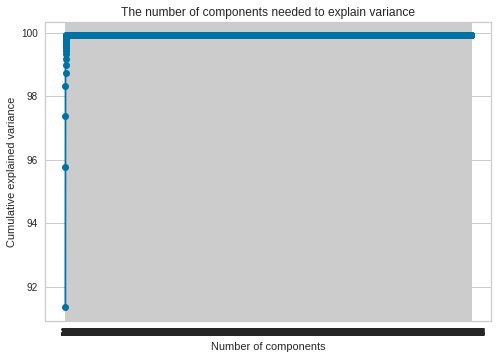

In [15]:
eig_vals_total = sum(eig_vals)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals_sorted]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

plt.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
plt.xticks(np.arange(1,n_features+1))
plt.title('The number of components needed to explain variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.show()

###Step 6: Project the data###
Finally, we can transform the data X_std via the projection matrix  W  to obtain a  k -dimensional feature subspace.

In [16]:
X_proj = X_std.dot(W.T)

print(X_proj.shape)

(365, 11)


Here, we visualize the transformed data in PCA space of the first two PCs: PC1 and PC2.

In [17]:
X_proj

,0,1,2,3,4,5,6,7,8,9,10
0,55.962487+0.000000j,-12.904872+0.000000j,6.946410+0.000000j,-11.510357+0.000000j,-1.037627+0.000000j,-5.504666+0.000000j,-0.685714+0.000000j,-1.743935+0.000000j,-0.276031+0.000000j,1.792301+0.000000j,0.647021+0.000000j
1,53.287099+0.000000j,-12.487316+0.000000j,-0.976119+0.000000j,-16.994991+0.000000j,-2.464521+0.000000j,-4.796049+0.000000j,-2.874611+0.000000j,-1.093163+0.000000j,0.867683+0.000000j,3.472642+0.000000j,-1.967364+0.000000j
2,51.401235+0.000000j,-12.253320+0.000000j,-9.520981+0.000000j,-19.427933+0.000000j,1.719673+0.000000j,-6.173030+0.000000j,-0.639749+0.000000j,1.482532+0.000000j,2.713989+0.000000j,5.042507+0.000000j,-3.845999+0.000000j
3,51.346758+0.000000j,-13.113691+0.000000j,-11.987418+0.000000j,-15.405208+0.000000j,4.861822+0.000000j,-5.943165+0.000000j,-2.875398+0.000000j,5.309588+0.000000j,5.424587+0.000000j,-0.121215+0.000000j,-2.180231+0.000000j
4,46.145116+0.000000j,-10.669654+0.000000j,-9.227305+0.000000j,-16.935597+0.000000j,3.275386+0.000000j,-9.946409+0.000000j,-4.701819+0.000000j,3.440365+0.000000j,5.162475+0.000000j,1.917460+0.000000j,-0.923997+0.000000j
...,...,...,...,...,...,...,...,...,...,...,...
360,68.381307+0.000000j,-14.910634+0.000000j,-18.023843+0.000000j,-2.535703+0.000000j,-2.383407+0.000000j,5.944029+0.000000j,-4.640760+0.000000j,0.497020+0.000000j,-1.534887+0.000000j,4.137928+0.000000j,-0.249457+0.000000j
361,69.716229+0.000000j,-16.770801+0.000000j,-21.623720+0.000000j,-7.560398+0.000000j,-1.959615+0.000000j,6.679333+0.000000j,-1.789642+0.000000j,-3.413365+0.000000j,-3.527223+0.000000j,4.040410+0.000000j,0.194226+0.000000j
362,56.844414+0.000000j,-13.489054+0.000000j,-20.799748+0.000000j,-0.603595+0.000000j,-4.816999+0.000000j,2.085326+0.000000j,2.956161+0.000000j,-1.349182+0.000000j,1.389490+0.000000j,2.288571+0.000000j,3.326765+0.000000j
363,51.044290+0.000000j,-12.493255+0.000000j,-24.813367+0.000000j,-1.054956+0.000000j,-6.978435+0.000000j,0.604445+0.000000j,0.777966+0.000000j,2.738402+0.000000j,-0.911411+0.000000j,1.233934+0.000000j,0.506072+0.000000j


In [19]:
# plt.scatter(X_proj[:, 0], X_proj[:, 1], c = y)
# plt.xlabel('PC1'); plt.xticks([])
# plt.ylabel('PC2'); plt.yticks([])
# plt.title('2 components, captures {} of total variation'.format(cum_explained_variance[1]))
# plt.show()

In [23]:
class MyPCA:
    
    def __init__(self, n_components):
        self.n_components = n_components   
        
    def fit(self, X):
        # Standardize data 
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        X_std = (X - self.mean) / self.scale
        
        # Eigendecomposition of covariance matrix       
        cov_mat = np.cov(X_std.T)
        eig_vals, eig_vecs = np.linalg.eig(cov_mat) 
        
        # Adjusting the eigenvectors that are largest in absolute value to be positive    
        max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
        signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
        eig_vecs = eig_vecs*signs[np.newaxis,:]
        eig_vecs = eig_vecs.T
       
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        eig_vecs_sorted = np.array([x[1] for x in eig_pairs])
        
        self.components = eig_vecs_sorted[:self.n_components,:]
        
        # Explained variance ratio
        self.explained_variance_ratio = [i/np.sum(eig_vals) for i in eig_vals_sorted[:self.n_components]]
        
        self.cum_explained_variance = np.cumsum(self.explained_variance_ratio)

        return self

    def transform(self, X):
        X = X.copy()
        X_std = (X - self.mean) / self.scale
        X_proj = X_std.dot(self.components.T)
        
        return X_proj
# ---------------------------------------------------------
my_pca = MyPCA(n_components = 11).fit(X_proj)

print('Components:\n', my_pca.components)
print('Components:\n', len(my_pca.components))
print('Explained variance ratio from scratch:\n', my_pca.explained_variance_ratio)
print('Cumulative explained variance from scratch:\n', my_pca.cum_explained_variance)

X_proj = my_pca.transform(X_proj)
print('Transformed data shape from scratch:', X_proj.shape)

Components:
 [[ 7.10031570e-01+0.j  4.12415319e-01+0.j -3.45419930e-02-0.j
  -1.61797459e-01-0.j  1.44051009e-01+0.j  3.47527209e-01+0.j
  -1.51076517e-01-0.j -3.28041551e-01-0.j -4.88448348e-02-0.j
  -1.52518755e-01-0.j -2.80747425e-02-0.j]
 [-1.24616790e-03+0.j  7.80792520e-01+0.j  9.61363175e-03+0.j
   5.43036952e-02+0.j -4.62790902e-02+0.j -5.19636453e-01+0.j
   4.93426932e-02+0.j  3.31623559e-01+0.j  1.37061962e-02+0.j
   4.99891367e-02+0.j  7.79209492e-03+0.j]
 [-4.10703306e-04+0.j  9.86914549e-02+0.j  4.13948417e-03+0.j
   2.49681451e-02+0.j -2.09230096e-02+0.j  6.41802547e-01+0.j
   2.24475236e-02+0.j  7.59079897e-01+0.j  5.91669363e-03+0.j
   2.27722744e-02+0.j  3.35230108e-03+0.j]
 [-1.82443161e-03-0.j  1.96019352e-01+0.j  4.77347624e-02+0.j
   5.34549362e-01+0.j -3.65569532e-01-0.j  2.70934985e-01+0.j
   4.20664006e-01+0.j -3.08639631e-01-0.j  6.94303328e-02+0.j
   4.33578351e-01+0.j  3.84346631e-02+0.j]
 [ 1.65137705e-04+0.j -1.53812002e-02+0.j -7.75923356e-03+0.j
   7.9833

In [ ]:
#https://www.kaggle.com/code/ameynoolkar/pca-tutorial

import seaborn as sns

#Find the covariance matrix
X_cov = np.cov(X_std, rowvar=False)

#Create a covariance-matrix dataframe to plot the heatmap
X_cov_df = pd.DataFrame(data=X_cov, columns=X_std.columns, index=X_std.columns)
# plt.figure(figsize=(8,8))
# sns.heatmap(X_cov_df, vmax=1, square=True, annot=True, cmap='winter')

In [ ]:
X_corr_df = X_std.corr()
#plt.figure(figsize=(8,8))
#sns.heatmap(X_corr_df, vmax=1, square=True, annot=True, cmap='winter')

In [ ]:
np.isclose(X_cov_df, X_corr_df, atol=.01)

In [ ]:
e_values, e_vectors = np.linalg.eig(X_cov)
eigen_pairs = [(value, vector) for value, vector in zip(e_values, e_vectors)]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

e_values = [value for value, vector in eigen_pairs]
e_vectors = [vector for value, vector in eigen_pairs]

for value, vector in eigen_pairs:
    print(f"{np.around(value, 5)}\t{np.around(vector, 3)}")

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, len(e_values) + 1), e_values, marker='o', label='Eigen values of components')
plt.ylabel("Eigenvalues")
plt.xlabel("Principal components")
plt.title("Scree Plot")
plt.legend()

In [ ]:
cumulative_values = []
cum_sum = 0
for value in e_values:
    cum_sum += 100 * value/sum(e_values)
    cumulative_values.append(cum_sum)

plt.figure(figsize=(8, 8))
plt.plot(range(1, len(e_values) + 1), cumulative_values, marker='o', label='Cumulative variance explained')
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.title("Cumulative explained variance")
plt.legend()